# Detecting Frequent Opiate Prescription

# Importing all the packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, log_loss, roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression

# Data Preprocessing 

Upload the csv files and remove NaN values

In [2]:
pd.set_option('display.max_columns',None,'display.max_rows',None)

In [3]:
prescriber = pd.read_csv('prescriber-info.csv')

In [4]:
prescriber.columns

Index(['NPI', 'Gender', 'State', 'Credentials', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=256)

In [5]:
prescriber.isnull().sum()

NPI                                 0
Gender                              0
State                               0
Credentials                       763
Specialty                           0
ABILIFY                             0
ACETAMINOPHEN.CODEINE               0
ACYCLOVIR                           0
ADVAIR.DISKUS                       0
AGGRENOX                            0
ALENDRONATE.SODIUM                  0
ALLOPURINOL                         0
ALPRAZOLAM                          0
AMIODARONE.HCL                      0
AMITRIPTYLINE.HCL                   0
AMLODIPINE.BESYLATE                 0
AMLODIPINE.BESYLATE.BENAZEPRIL      0
AMOXICILLIN                         0
AMOX.TR.POTASSIUM.CLAVULANATE       0
AMPHETAMINE.SALT.COMBO              0
ATENOLOL                            0
ATORVASTATIN.CALCIUM                0
AVODART                             0
AZITHROMYCIN                        0
BACLOFEN                            0
BD.ULTRA.FINE.PEN.NEEDLE            0
BENAZEPRIL.H

In [6]:
prescriber.dropna(inplace=True)

In [7]:
len(prescriber['State'].unique())

57

In [8]:
len(prescriber['Credentials'].unique())

887

In [9]:
len(prescriber['Specialty'].unique())

108

In [10]:
prescriber.dtypes

NPI                                int64
Gender                            object
State                             object
Credentials                       object
Specialty                         object
ABILIFY                            int64
ACETAMINOPHEN.CODEINE              int64
ACYCLOVIR                          int64
ADVAIR.DISKUS                      int64
AGGRENOX                           int64
ALENDRONATE.SODIUM                 int64
ALLOPURINOL                        int64
ALPRAZOLAM                         int64
AMIODARONE.HCL                     int64
AMITRIPTYLINE.HCL                  int64
AMLODIPINE.BESYLATE                int64
AMLODIPINE.BESYLATE.BENAZEPRIL     int64
AMOXICILLIN                        int64
AMOX.TR.POTASSIUM.CLAVULANATE      int64
AMPHETAMINE.SALT.COMBO             int64
ATENOLOL                           int64
ATORVASTATIN.CALCIUM               int64
AVODART                            int64
AZITHROMYCIN                       int64
BACLOFEN        

In [11]:
opioid = pd.read_csv('opioids.csv')

In [12]:
opioid

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN
5,AVINZA,MORPHINE SULFATE
6,BELLADONNA-OPIUM,OPIUM/BELLADONNA ALKALOIDS
7,BUPRENORPHINE HCL,BUPRENORPHINE HCL
8,BUTALB-ACETAMINOPH-CAFF-CODEIN,BUTALBIT/ACETAMIN/CAFF/CODEINE
9,BUTALB-CAFF-ACETAMINOPH-CODEIN,BUTALBIT/ACETAMIN/CAFF/CODEINE


In [13]:
opioid[opioid['Generic Name'].str.contains('NOPHEN',case=False)]

,Drug Name,Generic Name
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
13,CAPITAL W-CODEINE,ACETAMINOPHEN WITH CODEINE
17,CO-GESIC,HYDROCODONE/ACETAMINOPHEN
28,ENDOCET,OXYCODONE HCL/ACETAMINOPHEN
36,HYCET,HYDROCODONE/ACETAMINOPHEN
37,HYDROCODONE-ACETAMINOPHEN,HYDROCODONE/ACETAMINOPHEN
47,LORCET,HYDROCODONE/ACETAMINOPHEN
48,LORCET 10-650,HYDROCODONE/ACETAMINOPHEN
49,LORCET HD,HYDROCODONE/ACETAMINOPHEN
50,LORCET PLUS,HYDROCODONE/ACETAMINOPHEN


In [14]:
prescriber['Opioid.Prescriber'].value_counts()

1    14281
0     9956
Name: Opioid.Prescriber, dtype: int64

In [15]:
prescriber.columns

Index(['NPI', 'Gender', 'State', 'Credentials', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=256)

In [16]:
prescriber.dtypes

NPI                                int64
Gender                            object
State                             object
Credentials                       object
Specialty                         object
ABILIFY                            int64
ACETAMINOPHEN.CODEINE              int64
ACYCLOVIR                          int64
ADVAIR.DISKUS                      int64
AGGRENOX                           int64
ALENDRONATE.SODIUM                 int64
ALLOPURINOL                        int64
ALPRAZOLAM                         int64
AMIODARONE.HCL                     int64
AMITRIPTYLINE.HCL                  int64
AMLODIPINE.BESYLATE                int64
AMLODIPINE.BESYLATE.BENAZEPRIL     int64
AMOXICILLIN                        int64
AMOX.TR.POTASSIUM.CLAVULANATE      int64
AMPHETAMINE.SALT.COMBO             int64
ATENOLOL                           int64
ATORVASTATIN.CALCIUM               int64
AVODART                            int64
AZITHROMYCIN                       int64
BACLOFEN        

# Feature Selection 

Feature Selection Using Light GBM

In [17]:
dfcopy=prescriber.copy()


In [18]:
dfcopy.dtypes

NPI                                int64
Gender                            object
State                             object
Credentials                       object
Specialty                         object
ABILIFY                            int64
ACETAMINOPHEN.CODEINE              int64
ACYCLOVIR                          int64
ADVAIR.DISKUS                      int64
AGGRENOX                           int64
ALENDRONATE.SODIUM                 int64
ALLOPURINOL                        int64
ALPRAZOLAM                         int64
AMIODARONE.HCL                     int64
AMITRIPTYLINE.HCL                  int64
AMLODIPINE.BESYLATE                int64
AMLODIPINE.BESYLATE.BENAZEPRIL     int64
AMOXICILLIN                        int64
AMOX.TR.POTASSIUM.CLAVULANATE      int64
AMPHETAMINE.SALT.COMBO             int64
ATENOLOL                           int64
ATORVASTATIN.CALCIUM               int64
AVODART                            int64
AZITHROMYCIN                       int64
BACLOFEN        

In [19]:
dfcopy.shape

(24237, 256)

In [20]:
dfcopy.drop(['Opioid.Prescriber'],axis=1,inplace=True)

In [21]:
catList= ['Gender', 'State', 'Credentials', 'Specialty']
for i in catList:
    dfcopy[i]=dfcopy[i].astype('category')

C:\Users\brindhay\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\brindhay\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Credentials', 'Gender', 'Specialty', 'State']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


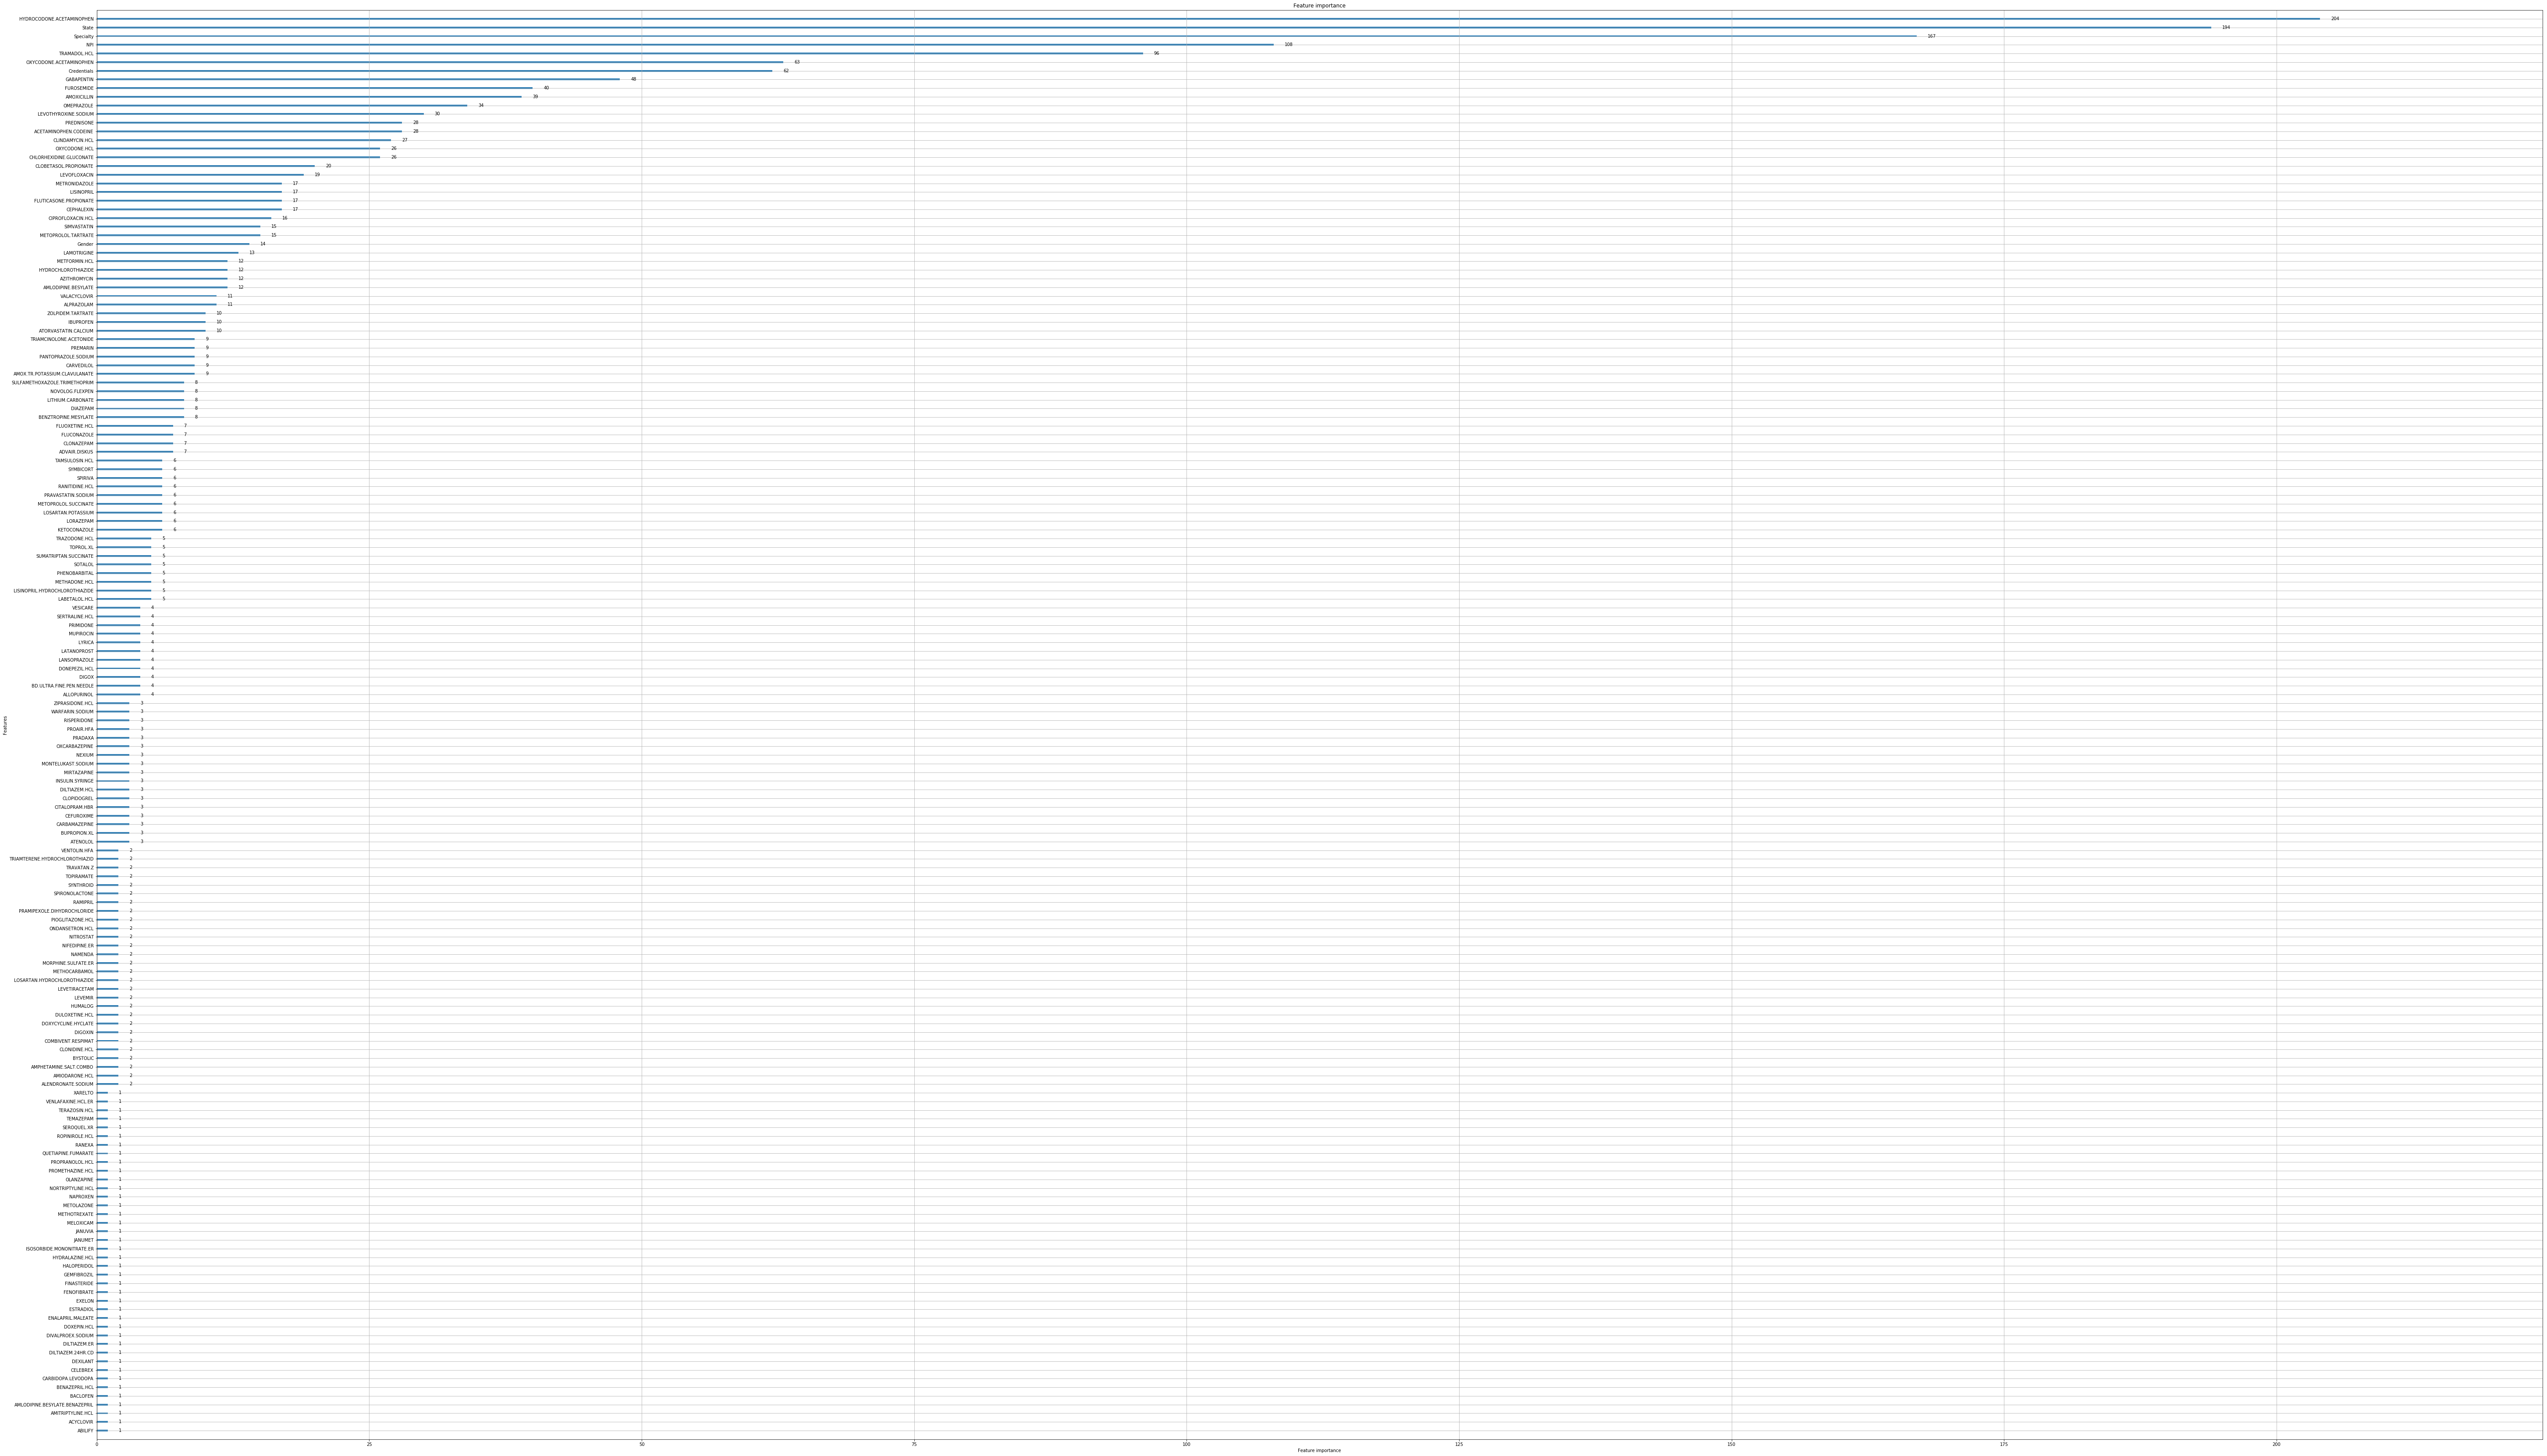

In [22]:

d_train = lgb.Dataset(dfcopy, label = prescriber['Opioid.Prescriber'])
params = {"max_depth":5, "learning_rate":0.1,"num_leaves":900,"n_estimators":100}
model2 = lgb.train(params = params,train_set = d_train,categorical_feature = catList)
ax = lgb.plot_importance(model2,max_num_features=256,figsize=(100,60))
plt.show()


In [23]:
prescriber.isnull().sum()

NPI                               0
Gender                            0
State                             0
Credentials                       0
Specialty                         0
ABILIFY                           0
ACETAMINOPHEN.CODEINE             0
ACYCLOVIR                         0
ADVAIR.DISKUS                     0
AGGRENOX                          0
ALENDRONATE.SODIUM                0
ALLOPURINOL                       0
ALPRAZOLAM                        0
AMIODARONE.HCL                    0
AMITRIPTYLINE.HCL                 0
AMLODIPINE.BESYLATE               0
AMLODIPINE.BESYLATE.BENAZEPRIL    0
AMOXICILLIN                       0
AMOX.TR.POTASSIUM.CLAVULANATE     0
AMPHETAMINE.SALT.COMBO            0
ATENOLOL                          0
ATORVASTATIN.CALCIUM              0
AVODART                           0
AZITHROMYCIN                      0
BACLOFEN                          0
BD.ULTRA.FINE.PEN.NEEDLE          0
BENAZEPRIL.HCL                    0
BENICAR                     

In [24]:
model2.feature_importance()

array([108,  14, 194,  62, 167,   1,  28,   1,   7,   0,   2,   4,  11,
         2,   1,  12,   1,  39,   9,   2,   3,  10,   0,  12,   1,   4,
         1,   0,   0,   8,   0,   0,   0,   0,   3,   0,   2,   3,   1,
         0,   0,   9,   3,   1,  17,  26,   0,   0,  16,   3,  27,  20,
         7,   2,   3,   0,   0,   2,   0,   0,   1,   8,   0,   0,   4,
         2,   1,   0,   1,   3,   0,   0,   1,   0,   4,   0,   0,   1,
         2,   2,   1,   0,   1,   1,   0,   0,   1,   0,   1,   0,   7,
         7,  17,  40,  48,   1,   0,   0,   0,   0,   0,   1,   2,   1,
        12, 204,   0,   0,   0,   0,  10,   3,   0,   0,   1,   0,   1,
         1,   6,   0,   0,   0,   5,   0,  13,   4,   0,   0,   4,   2,
         0,   2,  19,  30,   0,  17,   5,   8,   6,   2,   6,   0,   0,
         0,   4,   0,   1,  12,   0,   5,   2,   1,   0,   0,   1,   6,
        15,  17,   3,   3,   0,   2,   4,   0,   2,   0,   1,   0,   3,
         0,   0,   2,   0,   2,   1,   0,   8,   0,   1,  34,   

The features ranked above 28 are considered for the model

In [25]:
feature = list(model2.feature_importance())
effe_cols = []
for i in feature:
    if i >= 28:
        effe_cols.append(model2.feature_name()[feature.index(i)])
        feature[feature.index(i)]=0
prescrib = prescriber[effe_cols]
prescrib.head()

,NPI,State,Credentials,Specialty,ACETAMINOPHEN.CODEINE,AMOXICILLIN,FUROSEMIDE,GABAPENTIN,HYDROCODONE.ACETAMINOPHEN,LEVOTHYROXINE.SODIUM,OMEPRAZOLE,OXYCODONE.ACETAMINOPHEN,PREDNISONE,TRAMADOL.HCL
0,1710982582,TX,DDS,Dentist,0,0,0,0,17,0,0,0,0,0
1,1245278100,AL,MD,General Surgery,0,0,0,63,182,31,85,33,0,36
2,1427182161,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0
3,1669567541,AZ,MD,Internal Medicine,43,0,48,81,0,0,52,229,13,90
4,1679650949,NV,M.D.,Hematology/Oncology,0,0,0,0,22,0,0,0,0,0


In [26]:
prescrib['State'].unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'PR', 'CO', 'OH',
       'MA', 'FL', 'MN', 'UT', 'IA', 'IL', 'CT', 'MT', 'IN', 'VA', 'CA',
       'OR', 'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC',
       'NJ', 'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI',
       'WV', 'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD', 'AE', 'ZZ', 'GU',
       'AA', 'VI'], dtype=object)

In [27]:
len(prescrib['Credentials'].unique())

887

In [28]:
len(prescrib['Specialty'].unique())

108

In [29]:
del prescrib['NPI']


In [30]:
prescrib.columns

Index(['State', 'Credentials', 'Specialty', 'ACETAMINOPHEN.CODEINE',
       'AMOXICILLIN', 'FUROSEMIDE', 'GABAPENTIN', 'HYDROCODONE.ACETAMINOPHEN',
       'LEVOTHYROXINE.SODIUM', 'OMEPRAZOLE', 'OXYCODONE.ACETAMINOPHEN',
       'PREDNISONE', 'TRAMADOL.HCL'],
      dtype='object')

In [31]:
categorical=pd.read_csv('categorical.csv')

In [32]:
categorical.head()

,State,Credentials,Specialty,state1,Credentials1,Specialty1
0,TX,DDS,Dentist,47,242,18
1,AL,MD,General Surgery,3,505,28
2,NY,M.D.,General Practice,37,401,27
3,AZ,MD,Internal Medicine,5,505,41
4,NV,M.D.,Hematology/Oncology,36,401,35


# Label Encoding

In [33]:
lb = LabelEncoder()

In [34]:
pres_copy = prescrib.copy()

In [35]:
pres_copy.head()

,State,Credentials,Specialty,ACETAMINOPHEN.CODEINE,AMOXICILLIN,FUROSEMIDE,GABAPENTIN,HYDROCODONE.ACETAMINOPHEN,LEVOTHYROXINE.SODIUM,OMEPRAZOLE,OXYCODONE.ACETAMINOPHEN,PREDNISONE,TRAMADOL.HCL
0,TX,DDS,Dentist,0,0,0,0,17,0,0,0,0,0
1,AL,MD,General Surgery,0,0,0,63,182,31,85,33,0,36
2,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0
3,AZ,MD,Internal Medicine,43,0,48,81,0,0,52,229,13,90
4,NV,M.D.,Hematology/Oncology,0,0,0,0,22,0,0,0,0,0


In [36]:
pres_copy.iloc[:,0]=lb.fit_transform(pres_copy.iloc[:,1])

In [37]:
pres_copy.iloc[:,1]=lb.fit_transform(pres_copy.iloc[:,2].astype(str))

In [38]:
pres_copy.iloc[:,2]=lb.fit_transform(pres_copy.iloc[:,3])

In [39]:
pres_copy.head(10)

,State,Credentials,Specialty,ACETAMINOPHEN.CODEINE,AMOXICILLIN,FUROSEMIDE,GABAPENTIN,HYDROCODONE.ACETAMINOPHEN,LEVOTHYROXINE.SODIUM,OMEPRAZOLE,OXYCODONE.ACETAMINOPHEN,PREDNISONE,TRAMADOL.HCL
0,242,18,0,0,0,0,0,17,0,0,0,0,0
1,505,28,0,0,0,0,63,182,31,85,33,0,36
2,401,27,0,0,0,0,0,0,0,0,0,0,0
3,505,41,33,43,0,48,81,0,0,52,229,13,90
4,401,35,0,0,0,0,0,22,0,0,0,0,0
5,312,28,0,0,0,0,0,0,0,0,25,0,0
6,505,24,0,0,0,27,15,24,122,106,30,37,15
7,835,62,0,0,0,0,0,0,0,14,0,0,0
8,695,65,0,0,0,0,0,0,0,0,0,0,0
9,505,41,0,0,0,72,47,0,153,185,0,19,28


In [40]:
pres_copy['Opioid.Prescriber']=prescriber['Opioid.Prescriber']

In [41]:
pres_copy.isnull().sum()

State                        0
Credentials                  0
Specialty                    0
ACETAMINOPHEN.CODEINE        0
AMOXICILLIN                  0
FUROSEMIDE                   0
GABAPENTIN                   0
HYDROCODONE.ACETAMINOPHEN    0
LEVOTHYROXINE.SODIUM         0
OMEPRAZOLE                   0
OXYCODONE.ACETAMINOPHEN      0
PREDNISONE                   0
TRAMADOL.HCL                 0
Opioid.Prescriber            0
dtype: int64

In [42]:
del pres_copy['Opioid.Prescriber']

In [43]:
pres_copy.dtypes

State                        int64
Credentials                  int64
Specialty                    int64
ACETAMINOPHEN.CODEINE        int64
AMOXICILLIN                  int64
FUROSEMIDE                   int64
GABAPENTIN                   int64
HYDROCODONE.ACETAMINOPHEN    int64
LEVOTHYROXINE.SODIUM         int64
OMEPRAZOLE                   int64
OXYCODONE.ACETAMINOPHEN      int64
PREDNISONE                   int64
TRAMADOL.HCL                 int64
dtype: object

In [44]:
pres_copy.head()

,State,Credentials,Specialty,ACETAMINOPHEN.CODEINE,AMOXICILLIN,FUROSEMIDE,GABAPENTIN,HYDROCODONE.ACETAMINOPHEN,LEVOTHYROXINE.SODIUM,OMEPRAZOLE,OXYCODONE.ACETAMINOPHEN,PREDNISONE,TRAMADOL.HCL
0,242,18,0,0,0,0,0,17,0,0,0,0,0
1,505,28,0,0,0,0,63,182,31,85,33,0,36
2,401,27,0,0,0,0,0,0,0,0,0,0,0
3,505,41,33,43,0,48,81,0,0,52,229,13,90
4,401,35,0,0,0,0,0,22,0,0,0,0,0


In [45]:
x = pres_copy.values
x.shape

(24237, 13)

In [46]:
y = prescriber.iloc[:,-1].values
y.shape

(24237,)

In [47]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.2,random_state=42)

In [48]:
x_train

array([[505,  41,   0, ...,   0,   0,   0],
       [396,  99,   0, ...,   0,   0,   0],
       [401,  85,   0, ...,   0,   0,   0],
       ...,
       [ 83,  62,   0, ...,   0,  24,   0],
       [505,  25,   0, ...,   0,   0,   0],
       [401,  57,   0, ...,   0,   0,  12]], dtype=int64)

In [49]:
len(prescrib.columns)

13

In [50]:
pres_copy.columns

Index(['State', 'Credentials', 'Specialty', 'ACETAMINOPHEN.CODEINE',
       'AMOXICILLIN', 'FUROSEMIDE', 'GABAPENTIN', 'HYDROCODONE.ACETAMINOPHEN',
       'LEVOTHYROXINE.SODIUM', 'OMEPRAZOLE', 'OXYCODONE.ACETAMINOPHEN',
       'PREDNISONE', 'TRAMADOL.HCL'],
      dtype='object')

# Model Evaluation

In [51]:
models = []
name = []
results = []
models.append(('Decision Tree',DecisionTreeClassifier()))
models.append(('Random Forest',RandomForestClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Gradient Boosting',GradientBoostingClassifier()))
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = 42)
    cv_results = model_selection.cross_val_score(model,x_train,y_train,cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    msg = "%s: %f (std: %f)" % (name,cv_results.mean(),cv_results.std())
    print(msg)

Decision Tree: 0.895714 (std: 0.004668)
Random Forest: 0.902626 (std: 0.005758)
AdaBoost: 0.911136 (std: 0.006546)
Gradient Boosting: 0.911858 (std: 0.006973)


Graph showing comparison among different algorithms

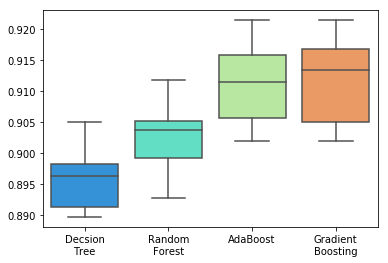

In [52]:
sns.boxplot( x = ['Decsion\nTree','Random\nForest','AdaBoost','Gradient\nBoosting'] , y= results, palette="rainbow")

Comparison of different algorithms for roc_auc scores

In [53]:
models = []
name = []
models.append(('Decision Tree',DecisionTreeClassifier()))
models.append(('Random Forest',RandomForestClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Gradient Boosting',GradientBoostingClassifier()))
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = 42)
    cv_results = model_selection.cross_val_score(model,x_train,y_train,cv = kfold, scoring = 'roc_auc')
    msg = "%s: %f (std: %f)" % (name,cv_results.mean(),cv_results.std())
    print(msg)

Decision Tree: 0.903933 (std: 0.006277)
Random Forest: 0.953106 (std: 0.004635)
AdaBoost: 0.959091 (std: 0.003970)
Gradient Boosting: 0.962753 (std: 0.003526)


As ROC score for Gradient Boosting classifier looks better, this classifier is chosen for model building.
Hyper Parameter tuning could be done to improve accuracy further.

# Model Building

In [54]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
predictions = gb.predict(x_test)
print('Accuracy: ',accuracy_score(y_test, predictions))
print('Log Loss: ',log_loss(y_test, gb.predict_proba(x_test)[:,1]))
print('ROC-AUC: ',roc_auc_score(y_test, gb.predict_proba(x_test)[:,1]))
print("Confusion Matrix:\n",confusion_matrix(y_test, predictions))
pd.crosstab(y_test,predictions,rownames=["True"],colnames=["False"],margins= True)

Accuracy:  0.9216171617161716
Log Loss:  0.1971618137506898
ROC-AUC:  0.9667560765993081
Confusion Matrix:
 [[1955   18]
 [ 362 2513]]


False,0,1,All
True,,,
0,1955,18,1973
1,362,2513,2875
All,2317,2531,4848


In [55]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, gb.predict_proba(x_test)[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

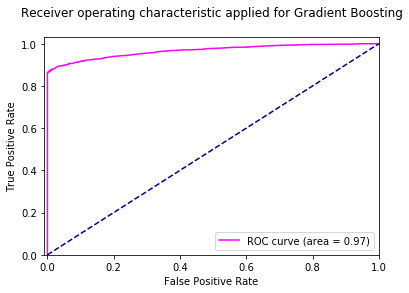

In [56]:
plt.plot(false_positive_rate,true_positive_rate, color='fuchsia', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic applied for Gradient Boosting\n')
plt.legend(loc="lower right")
plt.show()

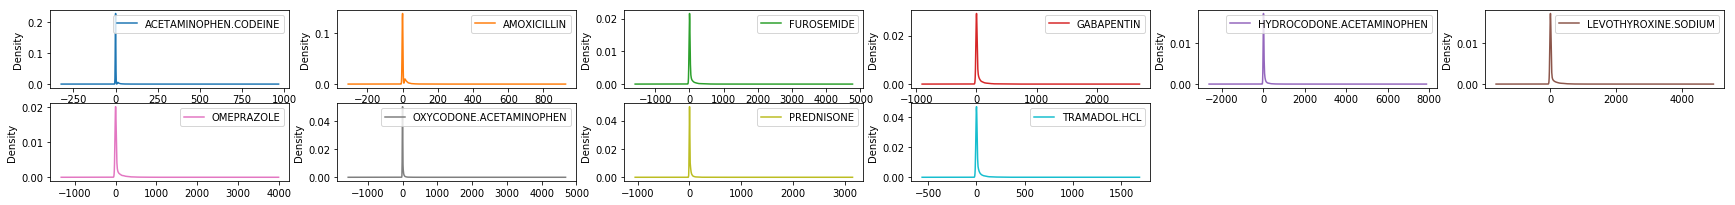

In [57]:
import matplotlib.pyplot as plt
prescrib.plot(kind='density', subplots=True, layout=(6,6), sharex=False,figsize=(30,10))
plt.show()

Text(0.5,1,'Correlation among features')

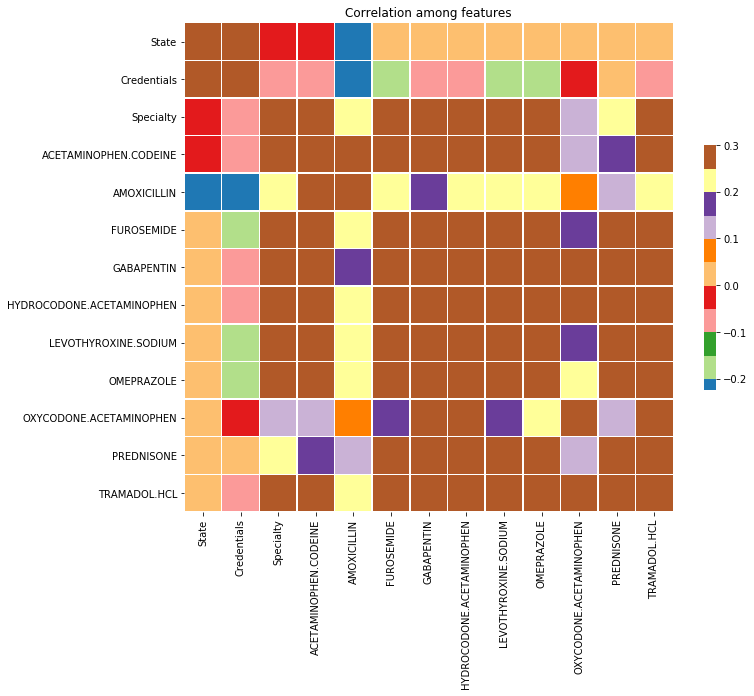

In [58]:
corr = pres_copy.corr()
f, ax = plt.subplots(figsize=(11, 9))
plot = sns.heatmap(corr, cmap='Paired', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Correlation among features")

In [59]:
import pickle
import os
# create the file paths
model_file_path = os.path.join(os.path.pardir,'final_data','Opiate','gb.pkl')
# open the files to write 
model_file_pickle = open(model_file_path, 'wb')
np.isnan(x_test)
pickle.dump(gb, model_file_pickle)
model_file_pickle.close()

In [60]:
categorical.to_csv('categorical_columns.csv',index=False)

In [61]:
prescrib.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24237 entries, 0 to 24999
Data columns (total 13 columns):
State                        24237 non-null object
Credentials                  24237 non-null object
Specialty                    24237 non-null object
ACETAMINOPHEN.CODEINE        24237 non-null int64
AMOXICILLIN                  24237 non-null int64
FUROSEMIDE                   24237 non-null int64
GABAPENTIN                   24237 non-null int64
HYDROCODONE.ACETAMINOPHEN    24237 non-null int64
LEVOTHYROXINE.SODIUM         24237 non-null int64
OMEPRAZOLE                   24237 non-null int64
OXYCODONE.ACETAMINOPHEN      24237 non-null int64
PREDNISONE                   24237 non-null int64
TRAMADOL.HCL                 24237 non-null int64
dtypes: int64(10), object(3)
memory usage: 2.6+ MB


In [62]:
model = LogisticRegression()
ac =model.fit(x_train, y_train)
predictions = ac.predict(x_test)
print('Accuracy: ',accuracy_score(y_test, predictions))
print('Log Loss: ',log_loss(y_test, model.predict_proba(x_test)[:,1]))
print('ROC-AUC: ',roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
print("Confusion Matrix:\n",confusion_matrix(y_test, predictions))
pd.crosstab(y_test,predictions,rownames=["True"],colnames=["False"],margins= True)
model.coef_

Accuracy:  0.9168729372937293
Log Loss:  0.22112683188848056
ROC-AUC:  0.9451837193415457
Confusion Matrix:
 [[1968    5]
 [ 398 2477]]


array([[2.28836557e-05, 2.47780984e-04, 1.45782909e-01, 5.20697222e-01,
        1.17401210e-04, 7.17890569e-04, 4.94871758e-03, 7.50920935e-01,
        1.26175274e-03, 2.10931296e-03, 6.57220780e-01, 6.53007141e-03,
        6.64420287e-01]])

In [63]:
import pickle
import os
# create the file paths
model_file_path = os.path.join(os.path.pardir,'final_data','Opiate','Logistic.pkl')
# open the files to write 
model_file_pickle = open(model_file_path, 'wb')
np.isnan(x_test)
pickle.dump(model, model_file_pickle)
model_file_pickle.close()
model.coef_

array([[2.28836557e-05, 2.47780984e-04, 1.45782909e-01, 5.20697222e-01,
        1.17401210e-04, 7.17890569e-04, 4.94871758e-03, 7.50920935e-01,
        1.26175274e-03, 2.10931296e-03, 6.57220780e-01, 6.53007141e-03,
        6.64420287e-01]])

In [64]:
load_model_logreg = pickle.load(open('Logistic.pkl', 'rb'))

In [65]:
load_model_logreg.coef_

array([[2.28836557e-05, 2.47780984e-04, 1.45782909e-01, 5.20697222e-01,
        1.17401210e-04, 7.17890569e-04, 4.94871758e-03, 7.50920935e-01,
        1.26175274e-03, 2.10931296e-03, 6.57220780e-01, 6.53007141e-03,
        6.64420287e-01]])

In [66]:
load_model_logreg.coef_.tolist()


[[2.2883655691750608e-05,
  0.0002477809842635781,
  0.1457829092261183,
  0.5206972219044494,
  0.00011740121010178975,
  0.0007178905685082252,
  0.00494871758157464,
  0.7509209352715612,
  0.0012617527413809693,
  0.0021093129578282368,
  0.6572207801924893,
  0.006530071411860267,
  0.6644202865592531]]

In [67]:
prescrib.columns

Index(['State', 'Credentials', 'Specialty', 'ACETAMINOPHEN.CODEINE',
       'AMOXICILLIN', 'FUROSEMIDE', 'GABAPENTIN', 'HYDROCODONE.ACETAMINOPHEN',
       'LEVOTHYROXINE.SODIUM', 'OMEPRAZOLE', 'OXYCODONE.ACETAMINOPHEN',
       'PREDNISONE', 'TRAMADOL.HCL'],
      dtype='object')

# User Inputs

In [68]:
def load_model():
    """This function load the pickled model as API for flask
         :returns: loaded_model
         :rtype: float64
         method's invoked:  None"""
    loaded_model = pickle.load(open('Gradient.pkl', 'rb'))
    return loaded_model
def load_model_lr():
    """This function load the pickled model as API for flask
         :returns: loaded_model
         :rtype: float64
         method's invoked:  None"""
    load_model_logreg = pickle.load(open('Logistic.pkl', 'rb'))
    return load_model_logreg


def total_weight_find(col_values, col_intercept):
    total_weight = 0
    for i in range(len(col_values)):
        total_weight = total_weight + (col_values[i] * col_intercept[0][i])
    return total_weight

In [69]:
Opiate=pd.DataFrame()

In [70]:
Opiate

""


In [73]:
print("Enter state")
Opiate.loc[0,'state'] = (input())

Enter state
TX


In [72]:
print("Enter Credentials")
Opiate.loc[0,'Credentials'] = (input())

Enter Credentials
MD


In [74]:
print("Enter Specialty")
Opiate.loc[0,'Specialty'] = (input())

Enter Specialty
Dentist


In [75]:
print("Enter ACETAMINOPHEN.CODEINE")
Opiate.loc[0,'ACETAMINOPHEN.CODEINE'] = (input())

Enter ACETAMINOPHEN.CODEINE
0


In [76]:
print("Enter AMOXICILLIN")
Opiate.loc[0,'AMOXICILLIN'] = (input())

Enter AMOXICILLIN
1


In [77]:
print("Enter FUROSEMIDE")
Opiate.loc[0,'FUROSEMIDE'] = (input())

Enter FUROSEMIDE
3


In [78]:
print("Enter GABAPENTIN")
Opiate.loc[0,'GABAPENTIN'] = (input())

Enter GABAPENTIN
5


In [79]:
print("Enter HYDROCODONE.ACETAMINOPHEN")
Opiate.loc[0,'HYDROCODONE.ACETAMINOPHEN'] = (input())

Enter HYDROCODONE.ACETAMINOPHEN
2


In [80]:
print("Enter LEVOTHYROXINE.SODIUM")
Opiate.loc[0,'LEVOTHYROXINE.SODIUM'] = (input())

Enter LEVOTHYROXINE.SODIUM
2


In [81]:
print("Enter OMEPRAZOLE")
Opiate.loc[0,'OMEPRAZOLE'] = (input())

Enter OMEPRAZOLE
5


In [82]:
print("Enter OXYCODONE.ACETAMINOPHEN")
Opiate.loc[0,'OXYCODONE.ACETAMINOPHEN'] = (input())

Enter OXYCODONE.ACETAMINOPHEN
1


In [83]:
print("Enter PREDNISONE")
Opiate.loc[0,'PREDNISONE'] = (input())

Enter PREDNISONE
7


In [84]:
print("Enter TRAMADOL.HCL")
Opiate.loc[0,'TRAMADOL.HCL'] = (input())

Enter TRAMADOL.HCL
9


In [85]:
state = Opiate.iat[0,0]
Credentials = Opiate.iat[0,1]
Specialty = Opiate.iat[0,2]
Ac = int(Opiate.iat[0,3])
AMOXICILLIN = int(Opiate.iat[0,4])
FUROSEMIDE = int(Opiate.iat[0,5])
GABAPENTIN = int(Opiate.iat[0,6])
Ha = int(Opiate.iat[0,7])
Ls = int(Opiate.iat[0,8])
OMEPRAZOLE = int(Opiate.iat[0,9])
Oa = int(Opiate.iat[0,10])
PREDNISONE = int(Opiate.iat[0,11])
Th = int(Opiate.iat[0,12])

In [88]:
categorical = pd.read_csv('categorical.csv')
state1 = int(categorical[categorical['State'] == state].iloc[0][3])
Credentials1 = int(categorical[categorical['Credentials'] == Credentials].iloc[1][4])
Specialty1 = int(categorical[categorical['Specialty'] == Specialty].iloc[2][5])
dataframe = ([[state1, Credentials1, Ac, AMOXICILLIN, FUROSEMIDE, GABAPENTIN,
          Ha, Ls, OMEPRAZOLE, Oa, PREDNISONE, Th, Specialty1]])
pdf = pd.DataFrame(dataframe)

In [89]:
pdf = pdf.rename(columns={0:'State', 1:'Credentials', 2:'Specialty', 3:'ACETAMINOPHEN.CODEINE',
       4:'AMOXICILLIN', 5:'FUROSEMIDE', 6:'GABAPENTIN', 7:'HYDROCODONE.ACETAMINOPHEN',
       8:'LEVOTHYROXINE.SODIUM', 9:'OMEPRAZOLE', 10:'OXYCODONE.ACETAMINOPHEN',
       11:'PREDNISONE', 12:'TRAMADOL.HCL'})

In [90]:
data = np.array(dataframe)
data

array([[ 47, 505,   0,   1,   3,   5,   2,   2,   5,   1,   7,   9,  18]])

In [91]:
model = load_model()
data = model.predict(data)

In [92]:
model_lr = load_model_lr()
col_list = [state1, Credentials1,Specialty1,Ac, AMOXICILLIN, FUROSEMIDE, GABAPENTIN,
            Ha, Ls, OMEPRAZOLE, Oa, PREDNISONE, Th]
intercept_values = model_lr.coef_.tolist()
total_weigh_data = total_weight_find(col_list, intercept_values)

In [93]:
w_state = ((state1 * intercept_values[0][0]) / total_weigh_data)
w_cred = ((Credentials1 * intercept_values[0][1]) / total_weigh_data)
w_spe = ((Specialty1 * intercept_values[0][2]) / total_weigh_data)
w_Ac = ((Ac * intercept_values[0][3]) / total_weigh_data)
w_am = ((AMOXICILLIN * intercept_values[0][4]) / total_weigh_data)
w_fu = ((FUROSEMIDE * intercept_values[0][5]) / total_weigh_data)
w_ga = ((GABAPENTIN * intercept_values[0][6]) / total_weigh_data)
w_ha = ((Ha * intercept_values[0][7]) / total_weigh_data)
w_ls = ((Ls * intercept_values[0][8]) / total_weigh_data)
w_om = ((OMEPRAZOLE * intercept_values[0][9]) / total_weigh_data)
w_oa = ((Oa * intercept_values[0][10]) / total_weigh_data)
w_pr = ((PREDNISONE * intercept_values[0][11]) / total_weigh_data)
w_th = ((Th * intercept_values[0][12]) / total_weigh_data)

In [94]:
total_pv = abs(w_state) + abs(w_cred) + abs(w_Ac) + abs(w_spe) + abs(w_am) + abs(w_fu) + abs(w_ga) + abs(
    w_ha) + abs(w_ls) + abs(w_om) + abs(w_oa) + abs(w_pr) + abs(w_th)
p_state = (w_state / total_pv) * 100
p_cred = (w_cred / total_pv) * 100
p_spe = (w_spe / total_pv) * 100
p_Ac = (w_Ac / total_pv) * 100
p_am = (w_am / total_pv) * 100
p_fu = (w_fu / total_pv) * 100
p_ga = (w_ga / total_pv) * 100
p_ha = (w_ha / total_pv) * 100
p_ls = (w_ls / total_pv) * 100
p_om = (w_om / total_pv) * 100
p_oa = (w_oa / total_pv) * 100
p_pr = (w_pr / total_pv) * 100
p_th = (w_th / total_pv) * 100

In [95]:
vb = [abs(round(p_state, 2)), abs(round(p_cred, 2)), abs(round(p_spe, 2)), abs(round(p_Ac, 2)),
      abs(round(p_am, 2)), abs(round(p_fu, 2)),abs(round(p_ga, 2)), abs(round(p_ha, 2)),
      abs(round(p_ls, 2)), abs(round(p_om, 2)), abs(round(p_oa, 2)),abs(round(p_pr, 2)), abs(round(p_th, 2))]
pro_col = [{"State": abs(round(p_state, 2)), "Credentials": abs(round(p_cred, 2)),
             "Specialty": abs(round(p_spe, 2)), "ACETAMINOPHEN.CODEINE": abs(round(p_Ac, 2)),
             "AMOXICILLIN": abs(round(p_am, 2)), "FUROSEMIDE": abs(round(p_fu, 2)),
             "GABAPENTIN": abs(round(p_ga, 2)), "HYDROCODONE.ACETAMINOPHEN": abs(round(p_ha, 2)),
              "LEVOTHYROXINE.SODIUM": abs(round(p_ls, 2)), "OMEPRAZOLE": abs(round(p_om, 2)),
              "OXYCODONE.ACETAMINOPHEN": abs(round(p_oa, 2)),
               "PREDNISONE": abs(round(p_pr, 2)), "TRAMADOL.HCL": abs(round(p_th, 2))}]

In [99]:
pro_col

[{'ACETAMINOPHEN.CODEINE': 0.0,
  'AMOXICILLIN': 0.0,
  'Credentials': 1.14,
  'FUROSEMIDE': 0.02,
  'GABAPENTIN': 0.23,
  'HYDROCODONE.ACETAMINOPHEN': 13.68,
  'LEVOTHYROXINE.SODIUM': 0.02,
  'OMEPRAZOLE': 0.1,
  'OXYCODONE.ACETAMINOPHEN': 5.99,
  'PREDNISONE': 0.42,
  'Specialty': 23.91,
  'State': 0.01,
  'TRAMADOL.HCL': 54.49}]

In [96]:
predicted_data = model.predict(pdf.values.astype('float'))
if data == 1:
    result = "Yes"
else:
    result = "No"

Based Upon the user inputs the graph will be generated

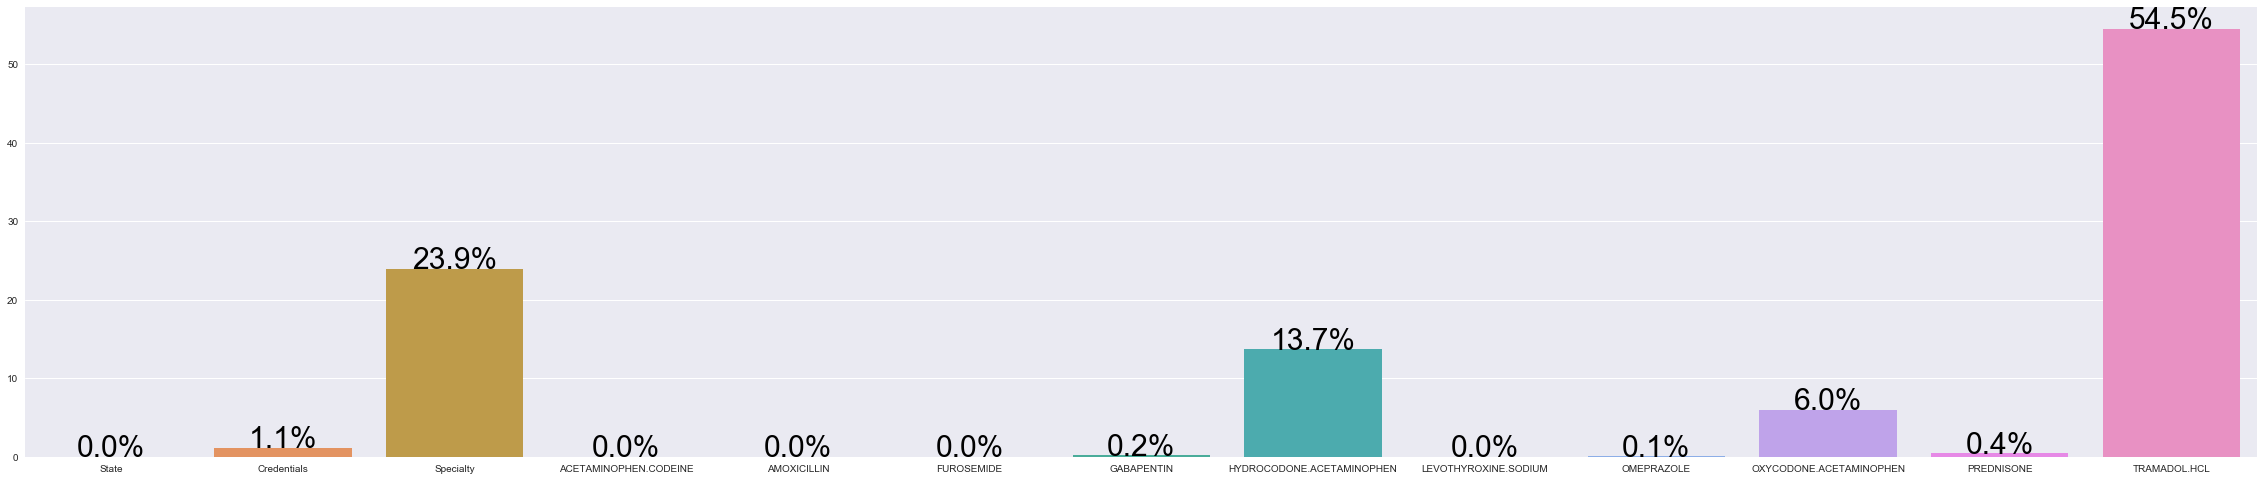

In [102]:
se=sns.barplot(y=vb,x=pdf.columns)
sns.set(rc={'figure.figsize':(40,8.27)})
k = 0
for p in se.patches:
    se.text(p.get_x()+p.get_width()/2.,
    p.get_height()+0.02,
    '{:1.1f}%'.format(vb[k]),
    ha="center",color='black',fontsize=30)
    k = k+1

